In [1]:
# Step 1: Clone the XGBoost repository
!git clone --recursive https://github.com/dmlc/xgboost

# Step 2: Navigate to the XGBoost directory
%cd xgboost

# Step 3: Install dependencies for building XGBoost
!apt-get install -y cmake build-essential libboost-dev

# Step 4: Build XGBoost from source
!mkdir build
%cd build
!cmake ..
!make -j$(nproc)
!sudo make install

# Step 5: Verify the installation
import xgboost
print(xgboost.__version__)


fatal: destination path 'xgboost' already exists and is not an empty directory.
/content/xgboost
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libboost-dev is already the newest version (1.74.0.3ubuntu7).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
mkdir: cannot create directory ‘build’: File exists
/content/xgboost/build
-- CMake version 3.31.2
-- xgboost VERSION: 3.0.0
-- Found OpenMP_C: -fopenmp (found version "4.5")
-- Found OpenMP_CXX: -fopenmp (found version "4.5")
-- Found OpenMP_C: -fopenmp (found version "4.5")
-- Found OpenMP_CXX: -fopenmp (found version "4.5")
-- /content/xgboost/dmlc-core/cmake/build_config.h.in -> include/dmlc/build_config.h
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /content/xgboost/build
[ 10%] Built target dmlc
[ 99

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
sepsis_data = pd.read_csv("/content/s41598-020-73558-3_sepsis_survival_primary_cohort.csv")
sepsis_data_val =pd.read_csv("/content/s41598-020-73558-3_sepsis_survival_validation_cohort.csv")

In [4]:
sepsis_data.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1


In [5]:
sepsis_data_val.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,20,0,1,1
1,22,0,1,1
2,26,1,2,0
3,33,1,1,1
4,33,0,1,1


In [6]:
sepsis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110204 entries, 0 to 110203
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   age_years                      110204 non-null  int64
 1   sex_0male_1female              110204 non-null  int64
 2   episode_number                 110204 non-null  int64
 3   hospital_outcome_1alive_0dead  110204 non-null  int64
dtypes: int64(4)
memory usage: 3.4 MB


In [7]:
# Check for missing values in both datasets
print("Missing Values in Primary Cohort:\n", sepsis_data.isnull().sum())

Missing Values in Primary Cohort:
 age_years                        0
sex_0male_1female                0
episode_number                   0
hospital_outcome_1alive_0dead    0
dtype: int64


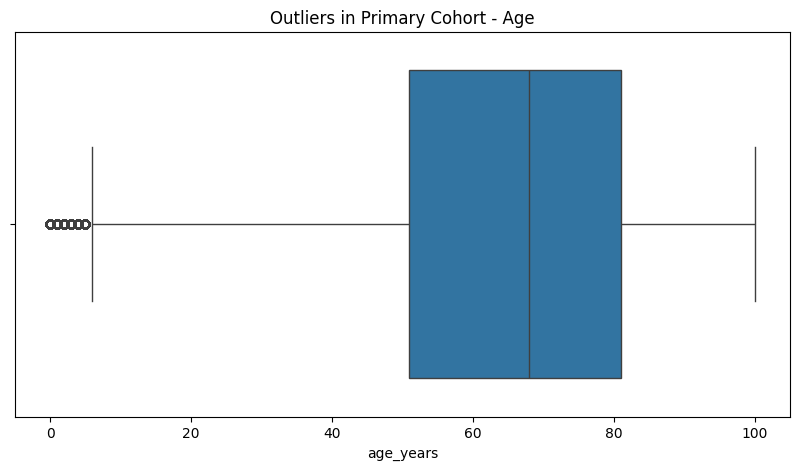

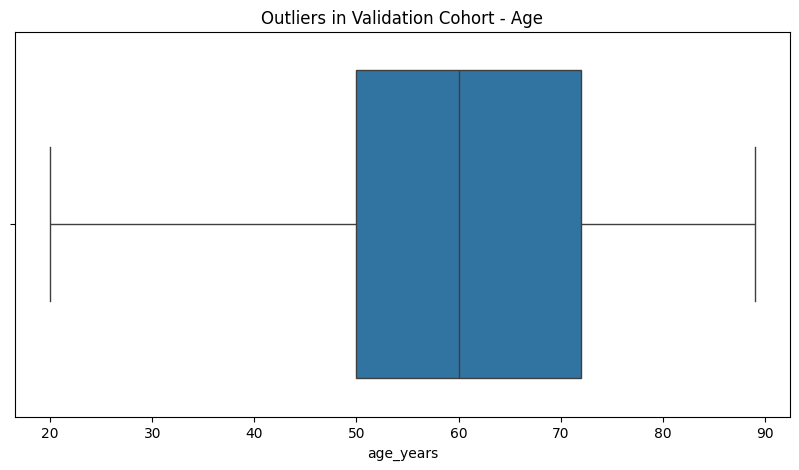

In [8]:
# Boxplot to check for outliers in 'age_years'
plt.figure(figsize=(10, 5))
sns.boxplot(data=sepsis_data, x='age_years')
plt.title("Outliers in Primary Cohort - Age")
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(data=sepsis_data_val, x='age_years')
plt.title("Outliers in Validation Cohort - Age")
plt.show()

In [9]:
# Removing outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers in 'age_years'
sepsis_data = remove_outliers(sepsis_data, 'age_years')

In [10]:
# Confirm results
print(f"Post-handling outliers in Primary Cohort: {sepsis_data['age_years'].describe()}")
print(f"Post-handling outliers in Validation Cohort: {sepsis_data_val['age_years'].describe()}")

Post-handling outliers in Primary Cohort: count    104974.000000
mean         65.786109
std          20.367968
min           6.000000
25%          55.000000
50%          70.000000
75%          82.000000
max         100.000000
Name: age_years, dtype: float64
Post-handling outliers in Validation Cohort: count    137.000000
mean      59.540146
std       15.748956
min       20.000000
25%       50.000000
50%       60.000000
75%       72.000000
max       89.000000
Name: age_years, dtype: float64


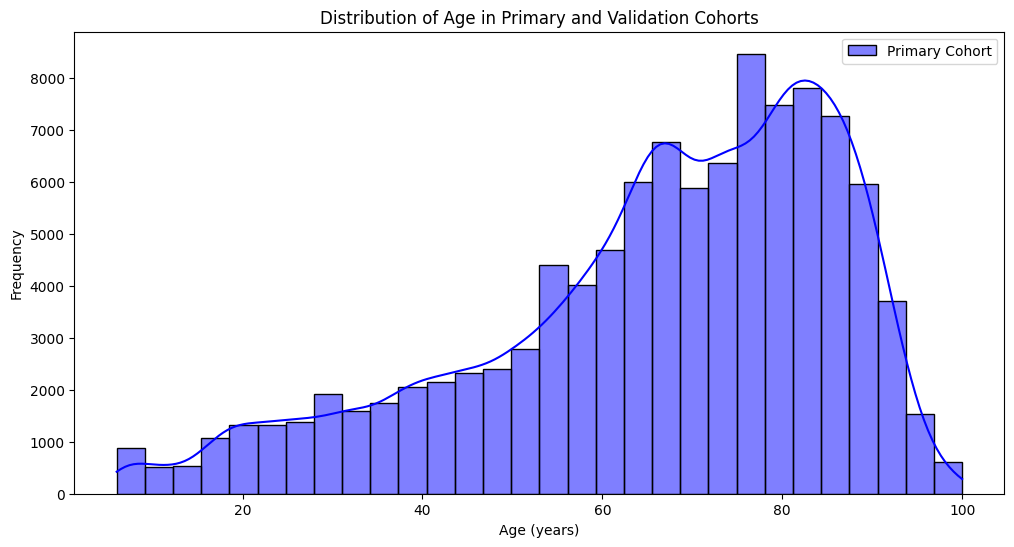

In [11]:
# Distribution of 'age_years' in primary and validation cohorts
plt.figure(figsize=(12, 6))
sns.histplot(sepsis_data['age_years'], kde=True, bins=30, color='blue', label='Primary Cohort')
plt.title('Distribution of Age in Primary and Validation Cohorts')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

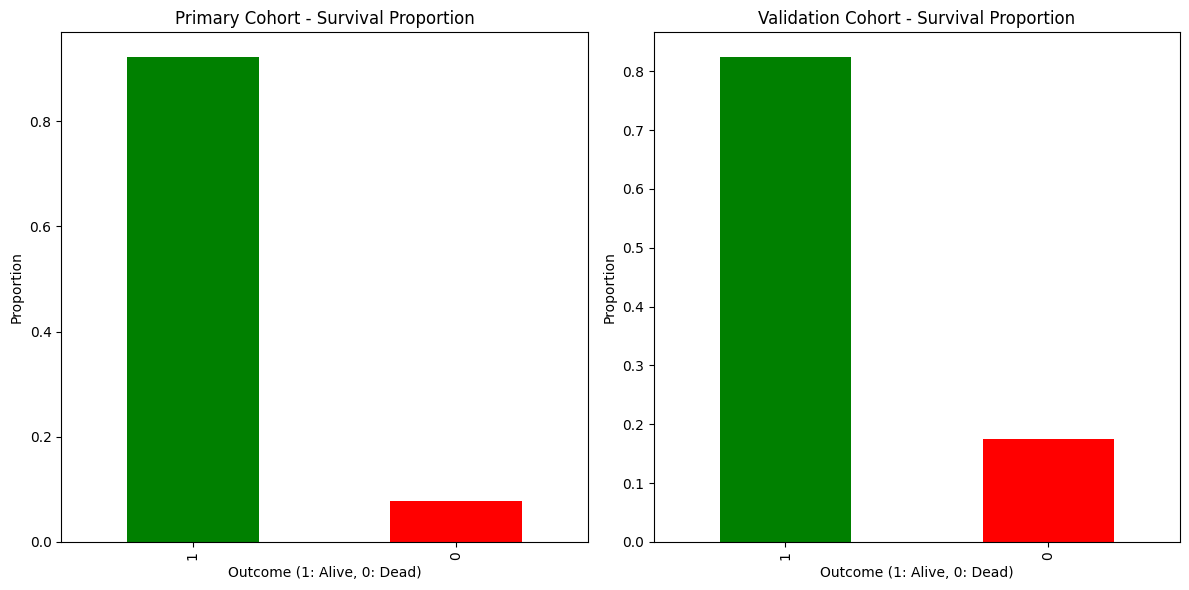

In [12]:
# Proportion of survival in both cohorts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sepsis_data['hospital_outcome_1alive_0dead'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
plt.title('Primary Cohort - Survival Proportion')
plt.xlabel('Outcome (1: Alive, 0: Dead)')
plt.ylabel('Proportion')

plt.subplot(1, 2, 2)
sepsis_data_val['hospital_outcome_1alive_0dead'].value_counts(normalize=True).plot(kind='bar', color=['green', 'red'])
plt.title('Validation Cohort - Survival Proportion')
plt.xlabel('Outcome (1: Alive, 0: Dead)')
plt.ylabel('Proportion')

plt.tight_layout()
plt.show()

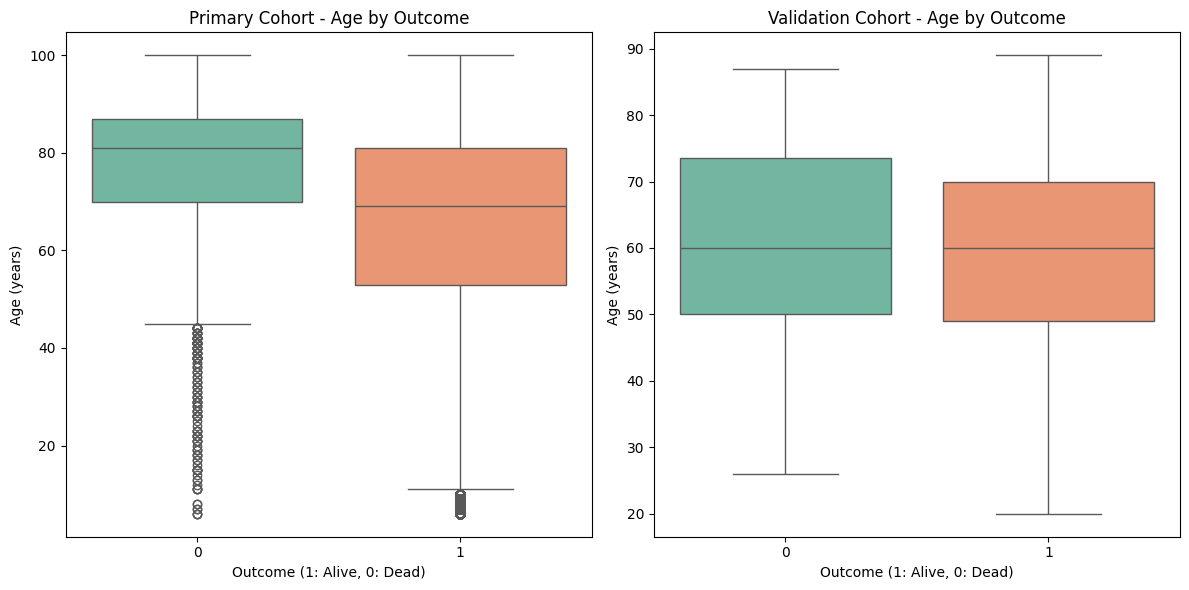

In [13]:
# Boxplot of age by outcome in both cohorts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=sepsis_data, x='hospital_outcome_1alive_0dead', y='age_years', palette='Set2')
plt.title('Primary Cohort - Age by Outcome')
plt.xlabel('Outcome (1: Alive, 0: Dead)')
plt.ylabel('Age (years)')

plt.subplot(1, 2, 2)
sns.boxplot(data=sepsis_data_val, x='hospital_outcome_1alive_0dead', y='age_years', palette='Set2')
plt.title('Validation Cohort - Age by Outcome')
plt.xlabel('Outcome (1: Alive, 0: Dead)')
plt.ylabel('Age (years)')

plt.tight_layout()
plt.show()

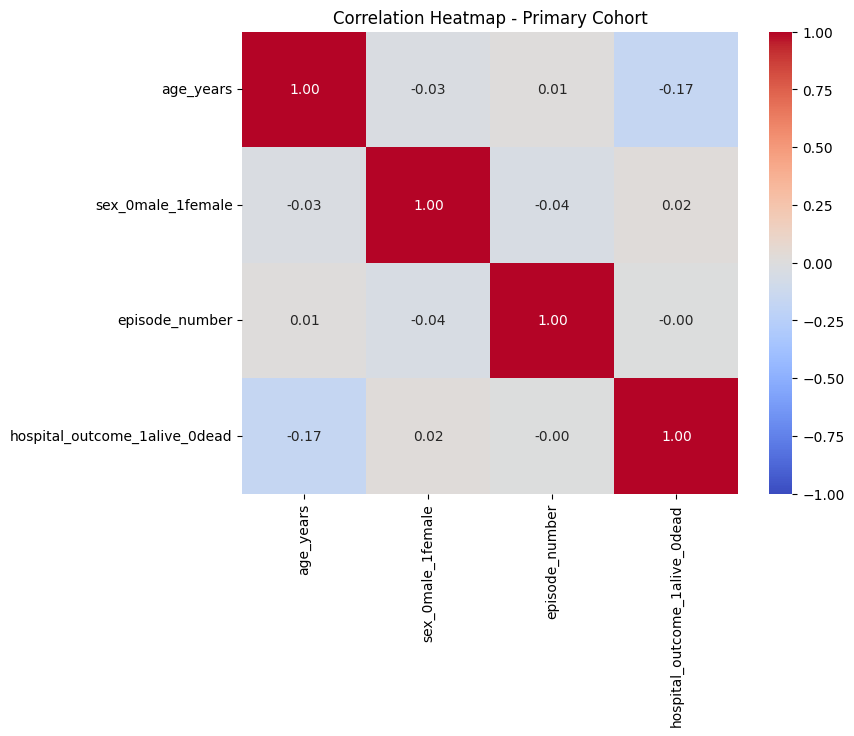

In [14]:
# Correlation heatmap for primary cohort
plt.figure(figsize=(8, 6))
sns.heatmap(sepsis_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - Primary Cohort')
plt.show()

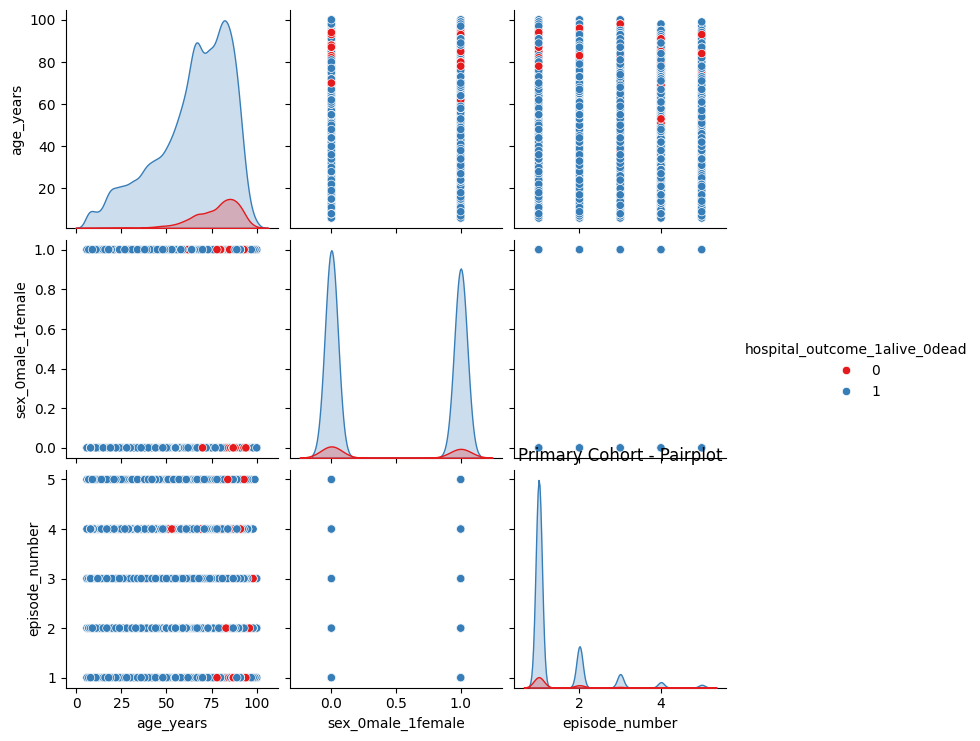

In [15]:
# Pairplot to observe relationships between numeric features
sns.pairplot(sepsis_data, hue='hospital_outcome_1alive_0dead', diag_kind='kde', palette='Set1')
plt.title('Primary Cohort - Pairplot')
plt.show()

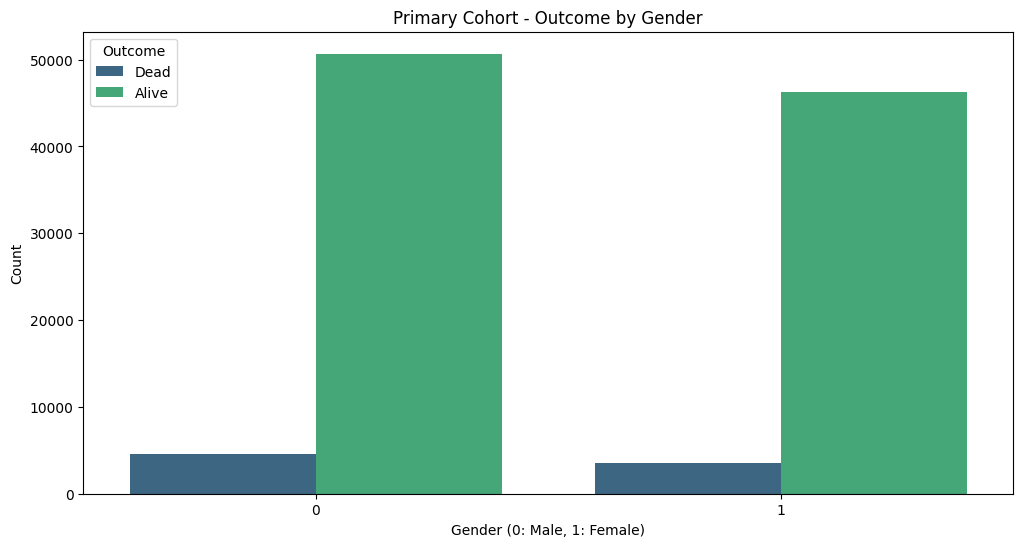

In [16]:
# Countplot of outcome by gender
plt.figure(figsize=(12, 6))
sns.countplot(data=sepsis_data, x='sex_0male_1female', hue='hospital_outcome_1alive_0dead', palette='viridis')
plt.title('Primary Cohort - Outcome by Gender')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')
plt.legend(title='Outcome', labels=['Dead', 'Alive'])
plt.show()

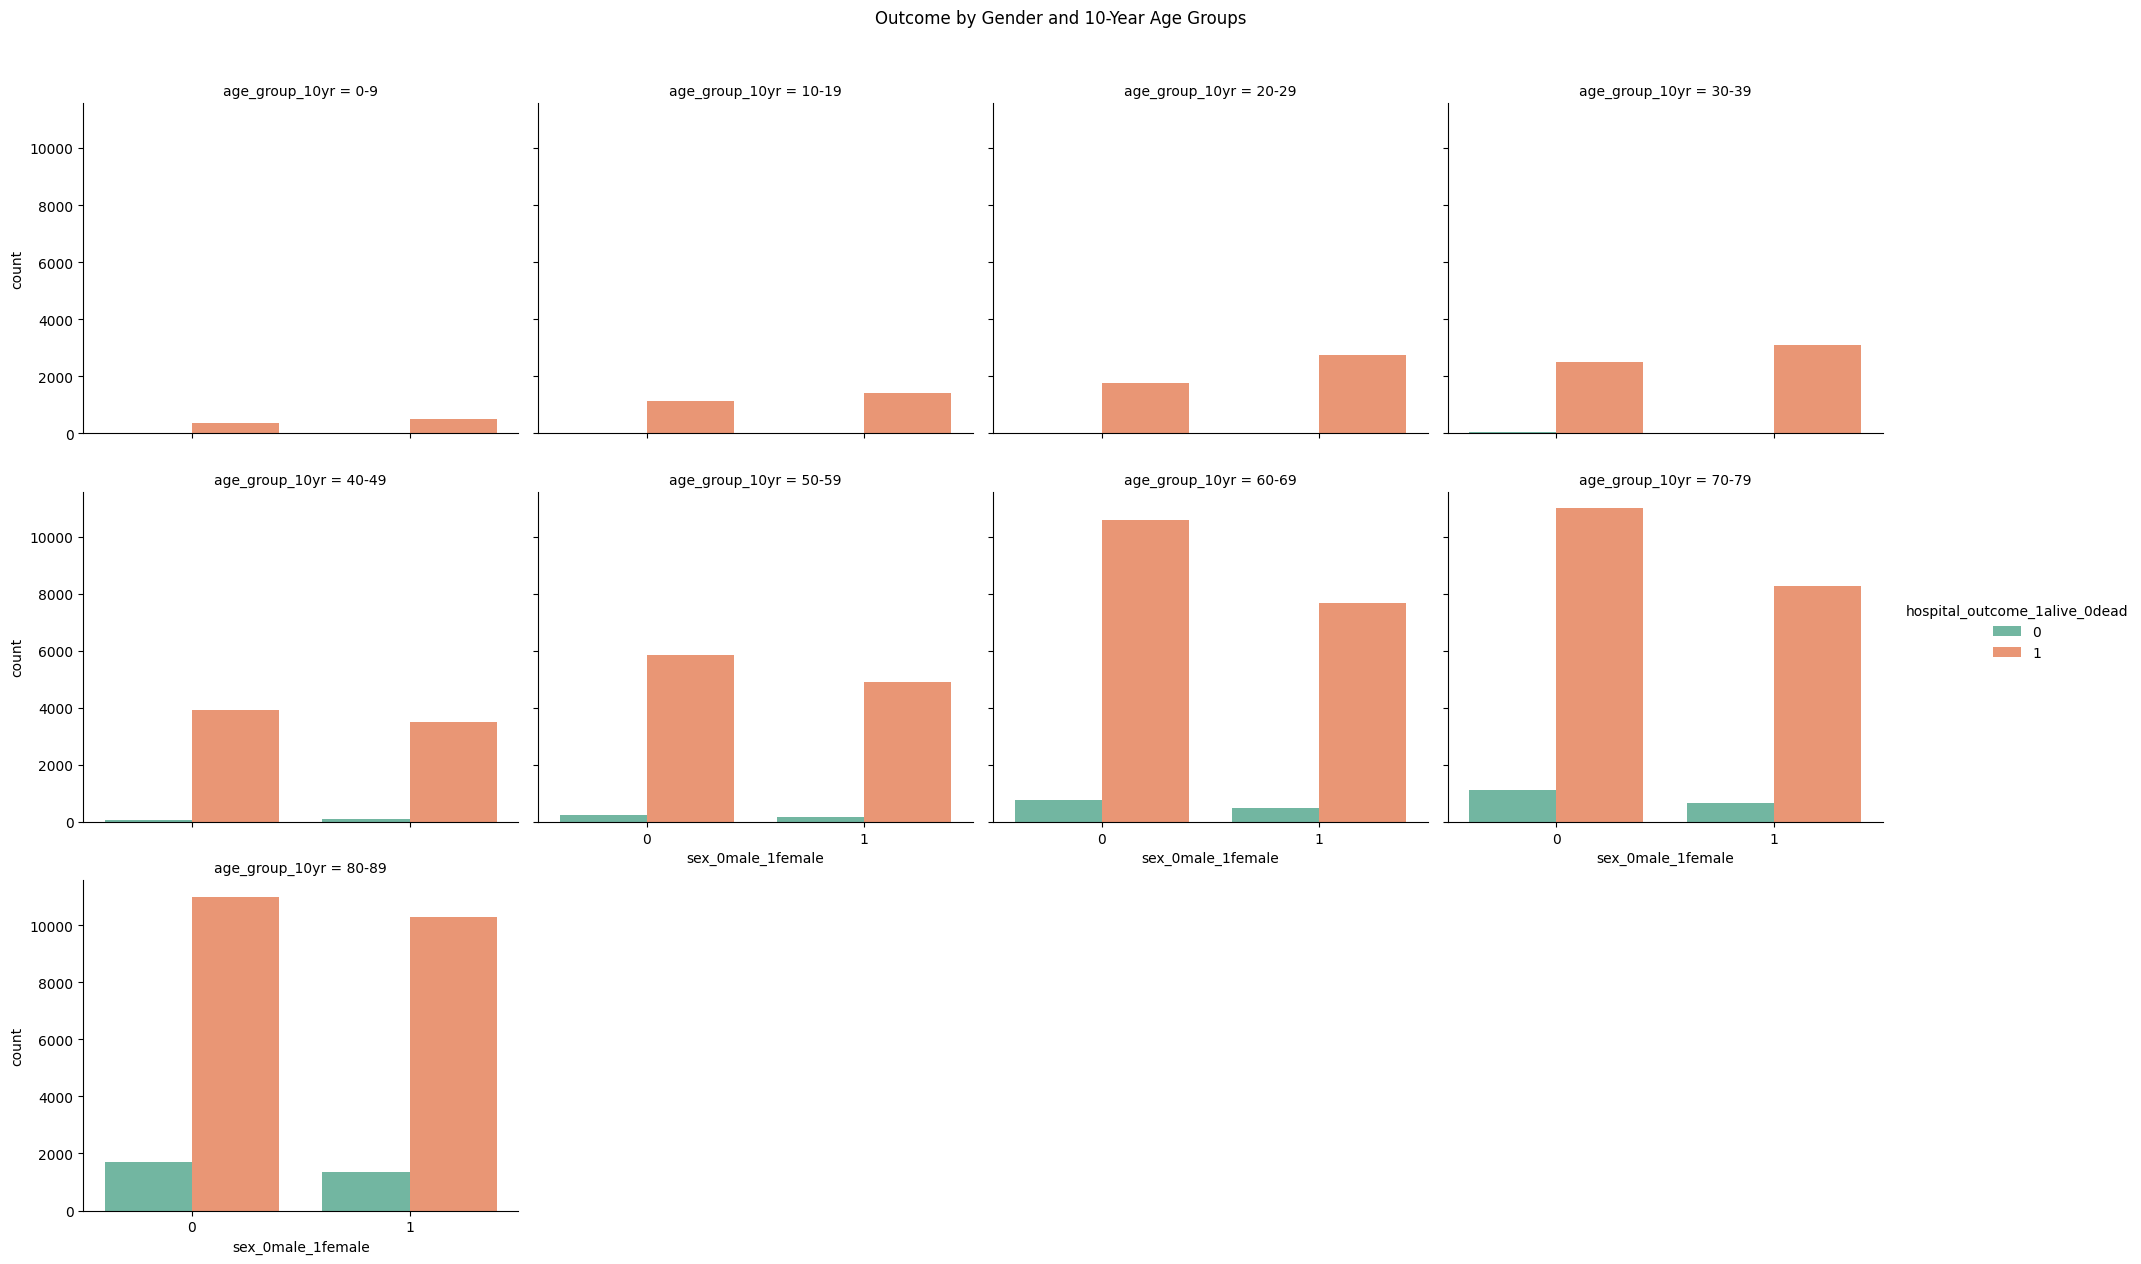

In [17]:
# Create 10-year age bins
sepsis_data['age_group_10yr'] = pd.cut(sepsis_data['age_years'], bins=range(0, 100, 10), right=False, labels=[f'{i}-{i+9}' for i in range(0, 90, 10)])

# Plot the count plot for each 10-year age group
sns.catplot(data=sepsis_data, x='sex_0male_1female', hue='hospital_outcome_1alive_0dead',
            col='age_group_10yr', kind='count', col_wrap=4, height=4, aspect=1.2, palette='Set2')

# Title adjustment
plt.suptitle('Outcome by Gender and 10-Year Age Groups', y=1.05)
plt.show()

In [18]:
np.random.seed(42)  # For reproducibility

# 1. Respiratory (PaO2/FiO2 ratio) for SOFA (scaled to typical clinical ranges)
sepsis_data['paO2_FiO2'] = np.random.uniform(100, 500, size=len(sepsis_data))  # Normal range for PaO2/FiO2

# 2. Coagulation (Platelet count in 10^3/μL) for SOFA (values ranging from 50 to 400)
sepsis_data['platelet_count'] = np.random.randint(50, 400, size=len(sepsis_data))

# 3. Liver (Bilirubin levels in mg/dL) for SOFA (normal range 0.1–1.2 mg/dL)
sepsis_data['bilirubin'] = np.random.uniform(0.1, 1.2, size=len(sepsis_data))

# 4. Cardiovascular (MAP or Vasopressor usage) for SOFA (MAP typically ranges 70-100 mmHg)
sepsis_data['MAP'] = np.random.uniform(70, 100, size=len(sepsis_data))

# 5. Renal (Serum creatinine in mg/dL) for SOFA (normal range: 0.5–1.5 mg/dL)
sepsis_data['creatinine'] = np.random.uniform(0.5, 1.5, size=len(sepsis_data))

# 6. Neurological (Glasgow Coma Scale) for SOFA (GCS ranges from 3 to 15)
sepsis_data['GCS'] = np.random.randint(3, 16, size=len(sepsis_data))

# qSOFA components
# 1. Respiratory rate (≥22 breaths per minute)
sepsis_data['respiratory_rate'] = np.random.randint(15, 30, size=len(sepsis_data))

# 2. Systolic Blood Pressure (≤100 mmHg for qSOFA)
sepsis_data['systolic_bp'] = np.random.randint(80, 120, size=len(sepsis_data))

# 3. Altered mental status (GCS < 15)
# If GCS < 15, flag for altered mental status (1 = Yes, 0 = No)
sepsis_data['altered_mental_status'] = np.where(sepsis_data['GCS'] < 15, 1, 0)

In [19]:
# Function to calculate SOFA score (based on the simplified scoring)
def calculate_sofa(row):
    # Respiratory
    if row['paO2_FiO2'] > 400:
        resp_score = 0
    elif 300 <= row['paO2_FiO2'] <= 400:
        resp_score = 1
    elif 200 <= row['paO2_FiO2'] < 300:
        resp_score = 2
    elif 100 <= row['paO2_FiO2'] < 200:
        resp_score = 3
    else:
        resp_score = 4

    # Coagulation (Platelets)
    if row['platelet_count'] > 150:
        coag_score = 0
    elif 100 <= row['platelet_count'] <= 150:
        coag_score = 1
    elif 50 <= row['platelet_count'] < 100:
        coag_score = 2
    else:
        coag_score = 3

    # Liver (Bilirubin)
    if row['bilirubin'] <= 1.2:
        liver_score = 0
    elif 1.2 < row['bilirubin'] <= 2:
        liver_score = 1
    elif 2 < row['bilirubin'] <= 3:
        liver_score = 2
    else:
        liver_score = 3

    # Cardiovascular (MAP)
    if row['MAP'] >= 70:
        cardio_score = 0
    elif 50 <= row['MAP'] < 70:
        cardio_score = 1
    elif 40 <= row['MAP'] < 50:
        cardio_score = 2
    else:
        cardio_score = 3

    # Renal (Creatinine)
    if row['creatinine'] <= 1.2:
        renal_score = 0
    elif 1.2 < row['creatinine'] <= 2:
        renal_score = 1
    elif 2 < row['creatinine'] <= 3:
        renal_score = 2
    else:
        renal_score = 3

    # Neurological (GCS)
    if row['GCS'] >= 15:
        neuro_score = 0
    elif 13 <= row['GCS'] < 15:
        neuro_score = 1
    elif 10 <= row['GCS'] < 13:
        neuro_score = 2
    else:
        neuro_score = 3

    # SOFA total score
    sofa_score = resp_score + coag_score + liver_score + cardio_score + renal_score + neuro_score
    return sofa_score

In [20]:
# Apply the SOFA calculation function
sepsis_data['SOFA_score'] = sepsis_data.apply(calculate_sofa, axis=1)

In [21]:
# Function to calculate qSOFA score
def calculate_qsofa(row):
    qsofa_score = 0
    # Respiratory rate (≥22 breaths per minute)
    if row['respiratory_rate'] >= 22:
        qsofa_score += 1
    # Altered mental status (GCS < 15)
    if row['altered_mental_status'] == 1:
        qsofa_score += 1
    # Systolic BP (≤100 mmHg)
    if row['systolic_bp'] <= 100:
        qsofa_score += 1
    return qsofa_score

In [22]:
# Apply the qSOFA calculation function
sepsis_data['qSOFA_score'] = sepsis_data.apply(calculate_qsofa, axis=1)

In [23]:
sepsis_data.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead,age_group_10yr,paO2_FiO2,platelet_count,bilirubin,MAP,creatinine,GCS,respiratory_rate,systolic_bp,altered_mental_status,SOFA_score,qSOFA_score
0,21,1,1,1,20-29,249.816048,238,0.881675,87.181965,1.182146,3,16,98,1,5,2
1,20,1,1,1,20-29,480.285723,286,1.100583,93.857117,0.685577,3,22,113,1,3,2
2,21,1,1,1,20-29,392.797577,274,0.429898,84.125976,1.067059,13,21,104,1,2,1
3,77,0,1,1,70-79,339.463394,73,0.636674,70.578305,0.905476,11,18,82,1,5,2
4,72,0,1,1,70-79,162.407456,79,0.299525,76.127218,1.329259,13,16,86,1,7,2


In [24]:
features = [
    'age_years',
    'sex_0male_1female',
    'episode_number',
    'paO2_FiO2',        # Respiratory feature for SOFA
    'platelet_count',   # Coagulation feature for SOFA
    'bilirubin',        # Liver feature for SOFA
    'MAP',              # Cardiovascular feature for SOFA
    'creatinine',       # Renal feature for SOFA
    'GCS',              # Neurological feature for SOFA
    'respiratory_rate', # Respiratory rate for qSOFA
    'systolic_bp',      # Systolic blood pressure for qSOFA
    'altered_mental_status'  # Altered mental status for qSOFA
]

target = 'hospital_outcome_1alive_0dead'

# Prepare features (X) and target (y)
X = sepsis_data[features]
y = sepsis_data[target]

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)

# Apply SMOTE to the entire dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution before and after applying SMOTE
print("Class distribution before SMOTE:", y.value_counts())
print("Class distribution after SMOTE:", pd.Series(y_resampled).value_counts())

# Now, split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

Class distribution before SMOTE: hospital_outcome_1alive_0dead
1    96899
0     8075
Name: count, dtype: int64
Class distribution after SMOTE: hospital_outcome_1alive_0dead
1    96899
0    96899
Name: count, dtype: int64
Training set shape: (155038, 12), Test set shape: (38760, 12)


In [25]:
# Initialize models
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
logreg_model = LogisticRegression(random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
knn_model = KNeighborsClassifier()

In [26]:
# Train Random Forest model
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [27]:
# Train XGBoost model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [28]:
# Train Logistic Regression model
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [29]:
# Train Decision Tree model
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [30]:
# Train K-Nearest Neighbors model
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
# Predict probabilities for ROC and Precision-Recall Curves
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
logreg_probs = logreg_model.predict_proba(X_test)[:, 1]
dt_probs = dt_model.predict_proba(X_test)[:, 1]
knn_probs = knn_model.predict_proba(X_test)[:, 1]

# Compute ROC and AUC for all models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_probs)

roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Compute Precision-Recall curve and AUC for all models
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_probs)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_probs)
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, logreg_probs)
precision_dt, recall_dt, _ = precision_recall_curve(y_test, dt_probs)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_probs)

pr_auc_rf = average_precision_score(y_test, rf_probs)
pr_auc_xgb = average_precision_score(y_test, xgb_probs)
pr_auc_logreg = average_precision_score(y_test, logreg_probs)
pr_auc_dt = average_precision_score(y_test, dt_probs)
pr_auc_knn = average_precision_score(y_test, knn_probs)

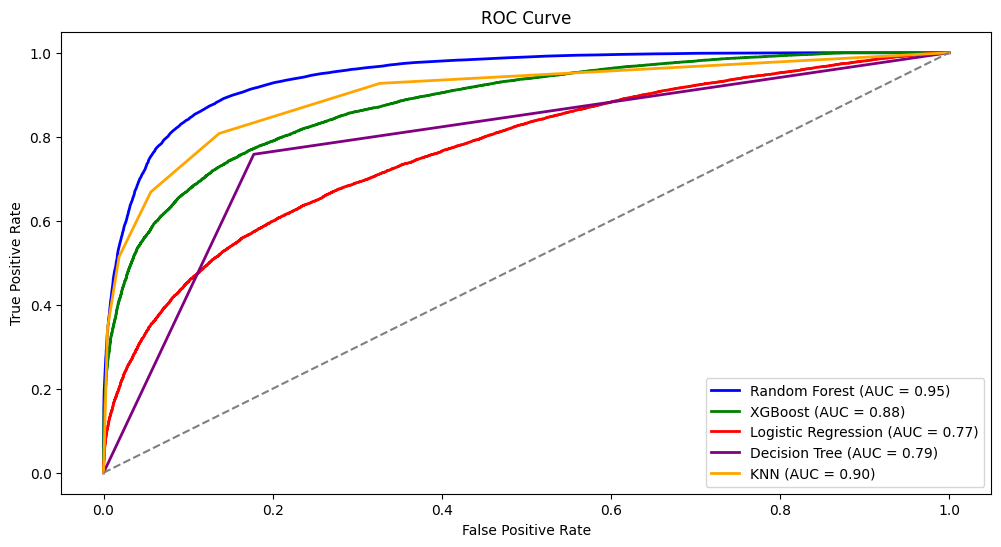

In [32]:
# Plot ROC Curves
plt.figure(figsize=(12, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_knn, tpr_knn, color='orange', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

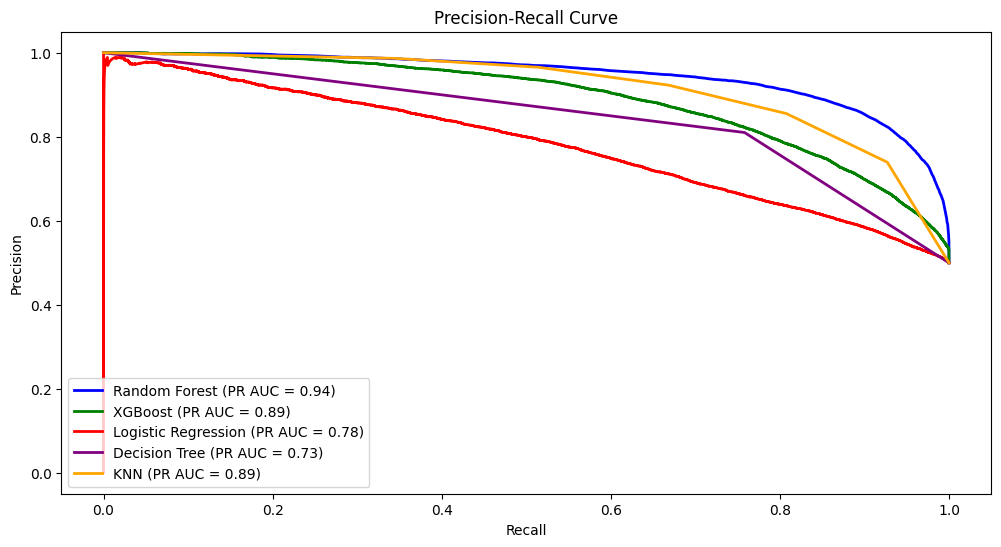

In [33]:
# Plot Precision-Recall Curves
plt.figure(figsize=(12, 6))
plt.plot(recall_rf, precision_rf, color='blue', lw=2, label=f'Random Forest (PR AUC = {pr_auc_rf:.2f})')
plt.plot(recall_xgb, precision_xgb, color='green', lw=2, label=f'XGBoost (PR AUC = {pr_auc_xgb:.2f})')
plt.plot(recall_logreg, precision_logreg, color='red', lw=2, label=f'Logistic Regression (PR AUC = {pr_auc_logreg:.2f})')
plt.plot(recall_dt, precision_dt, color='purple', lw=2, label=f'Decision Tree (PR AUC = {pr_auc_dt:.2f})')
plt.plot(recall_knn, precision_knn, color='orange', lw=2, label=f'KNN (PR AUC = {pr_auc_knn:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [34]:
# Classification Reports for all models
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_logreg = logreg_model.predict(X_test)
y_pred_dt = dt_model.predict(X_test)
y_pred_knn = knn_model.predict(X_test)

print("Classification Report of Random Forest Model: \n", classification_report(y_pred_rf, y_test))
print("Classification Report of XGBoost Model: \n", classification_report(y_pred_xgb, y_test))
print("Classification Report of Logistic Regression Model: \n", classification_report(y_pred_logreg, y_test))
print("Classification Report of Decision Tree Model: \n", classification_report(y_pred_dt, y_test))
print("Classification Report of KNN Model: \n", classification_report(y_pred_knn, y_test))

Classification Report of Random Forest Model: 
               precision    recall  f1-score   support

           0       0.90      0.85      0.87     20615
           1       0.84      0.90      0.87     18145

    accuracy                           0.87     38760
   macro avg       0.87      0.87      0.87     38760
weighted avg       0.87      0.87      0.87     38760

Classification Report of XGBoost Model: 
               precision    recall  f1-score   support

           0       0.83      0.78      0.80     20543
           1       0.77      0.82      0.79     18217

    accuracy                           0.80     38760
   macro avg       0.80      0.80      0.80     38760
weighted avg       0.80      0.80      0.80     38760

Classification Report of Logistic Regression Model: 
               precision    recall  f1-score   support

           0       0.74      0.68      0.71     20909
           1       0.66      0.72      0.69     17851

    accuracy                          

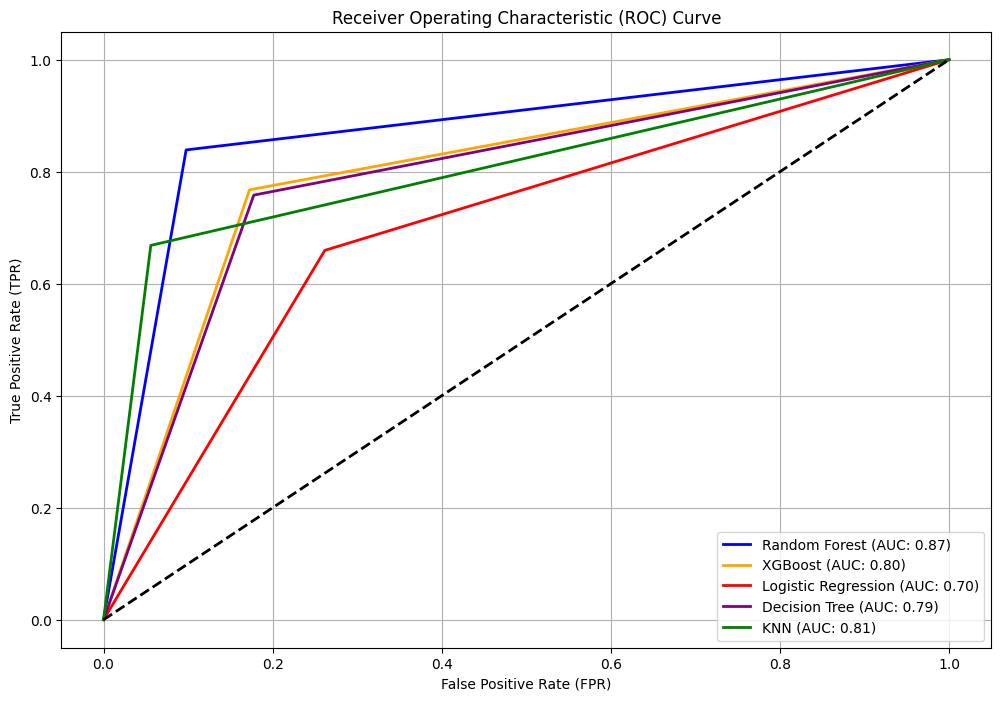

ROC AUC Score for Random Forest: 0.8706
ROC AUC Score for XGBoost: 0.7975
ROC AUC Score for Logistic Regression: 0.6989
ROC AUC Score for Decision Tree: 0.7903
ROC AUC Score for KNN: 0.8063


In [35]:
# Compute ROC and AUC for all models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_logreg)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)

roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC Curves for all models
plt.figure(figsize=(12, 8))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC: {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, color='orange', lw=2, label=f'XGBoost (AUC: {roc_auc_xgb:.2f})')
plt.plot(fpr_logreg, tpr_logreg, color='red', lw=2, label=f'Logistic Regression (AUC: {roc_auc_logreg:.2f})')
plt.plot(fpr_dt, tpr_dt, color='purple', lw=2, label=f'Decision Tree (AUC: {roc_auc_dt:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'KNN (AUC: {roc_auc_knn:.2f})')

# Plot diagonal line representing random chance
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Add titles and labels
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the ROC AUC Scores for all models
print(f"ROC AUC Score for Random Forest: {roc_auc_rf:.4f}")
print(f"ROC AUC Score for XGBoost: {roc_auc_xgb:.4f}")
print(f"ROC AUC Score for Logistic Regression: {roc_auc_logreg:.4f}")
print(f"ROC AUC Score for Decision Tree: {roc_auc_dt:.4f}")
print(f"ROC AUC Score for KNN: {roc_auc_knn:.4f}")